## Sprint 4: Build an initial ranking system by segment the merchants

### Step 1: Segment the merchants by cluster

Index(['Unnamed: 0', 'merchant_abn', 'count', 'dollar_sum',
       'fraud_probability_x', 'fraud_probability_y', 'cpi', 'state',
       'postcode', 'gender', 'is_fraud'],
      dtype='object')
[array(['Female', 'Male'], dtype=object)]


/tmp/ipykernel_358/3724554520.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster[name] = list(df_transformed[name])
/tmp/ipykernel_358/3724554520.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster[name] = list(df_transformed[name])
/tmp/ipykernel_358/3724554520.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


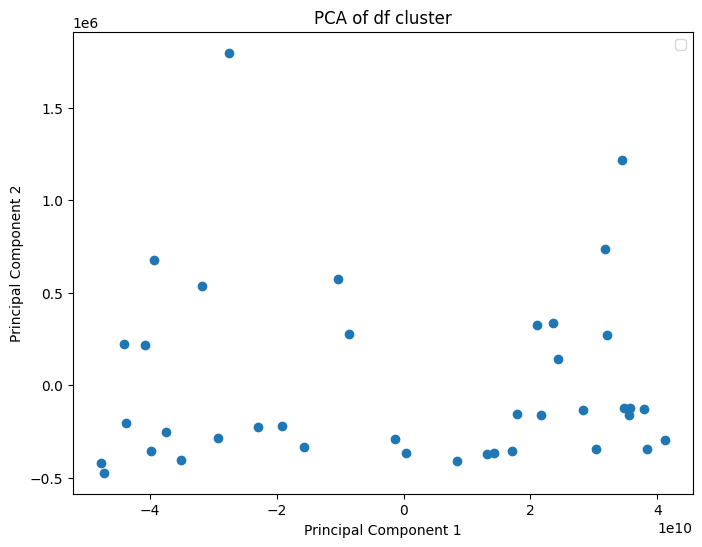

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def mode_calculator(col):
    values, counts = np.unique(col, return_counts=True)
    index = np.argmax(counts)
    return values[index]

ohe = OneHotEncoder()
df = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_week9.csv')
print(df.columns)
# Selection of variables for clustering
df_cluster = df[['merchant_abn', 'count', 'dollar_sum','fraud_probability_x', 'fraud_probability_y',  'gender']]
df_transformed = ohe.fit_transform(df[['gender']]).toarray()
print(ohe.categories_)
df_transformed = pd.DataFrame(df_transformed, columns=['Female', 'Male'])
for name in ['Female', 'Male']:
    df_cluster[name] = list(df_transformed[name])

df_cluster = df_cluster.drop('gender', axis=1)
# In order to be able to subsequently visualise the results of the clustering, we first extract the principal components with the aim of obtaining a 2-dimensional visualisation of the
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cluster)
x_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
# visualisation
plt.figure(figsize=(8, 6))
plt.scatter(x_pca['PC1'],x_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of df cluster')
plt.show()

In [2]:
feature_names = df_cluster.columns

# View the weights of each principal component
pca_components = pd.DataFrame(pca.components_, columns=feature_names, index=['PC1', 'PC2'])
print(pca_components)

     merchant_abn         count  dollar_sum  fraud_probability_x  \
PC1      1.000000 -3.292217e-10   -0.000002        -9.697610e-11   
PC2      0.000002  1.977339e-04    1.000000        -9.735815e-07   

     fraud_probability_y        Female          Male  
PC1         6.088266e-12 -1.198227e-12  1.198227e-12  
PC2         1.800404e-07  2.223908e-07 -2.223908e-07  


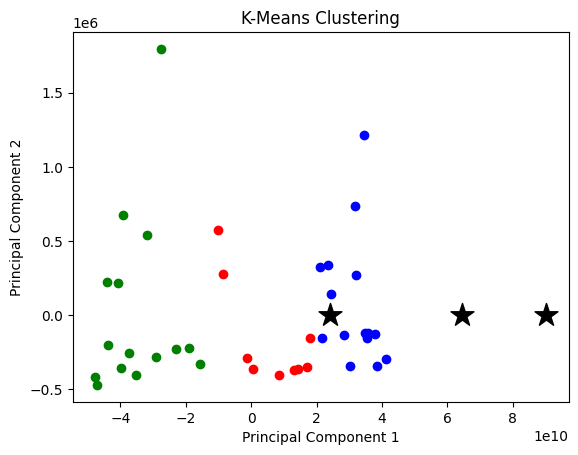

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_cluster)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
colors = ['r', 'g', 'b', 'c']
for i in range(len(x_pca)):
    plt.scatter(x_pca['PC1'][i], x_pca['PC2'][i], c=colors[labels[i]])
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=300, c='black')
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [4]:
# Observe the range of indicators for different categories as a means of identifying possible industries
df_cluster['label'] = kmeans.labels_
df_cluster.groupby('label').mean()

,merchant_abn,count,dollar_sum,fraud_probability_x,fraud_probability_y,Female,Male
label,,,,,,,
0,6.452309e+10,82.888889,326773.297712,28.063943,13.272712,0.666667,0.333333
1,2.407775e+10,127.800000,579965.745197,36.580467,12.890749,0.866667,0.133333
2,9.020712e+10,119.800000,524010.947121,30.437198,13.351923,0.866667,0.133333


Looking at the three categories, there is a very large into-phase difference in the mean value of dollar_value

For the first category, consumers favour women, spend the least, merchant fraud is the lowest, and user fraud is the highest, more in line with apparel companies

For the second category of companies, consumers are female-skewed, spend the most, merchant fraud is higher, and user fraud is higher, which is more in line with technology companies.

For the third category of companies, consumers are female-skewed, spending is very low, merchant fraud is low, and user fraud is high, more in line with food companies


### step2:  Curate our ranking systems for each segment

In [5]:
# When sorting, we consider the fact that there is less fraud, the amount of money involved in the fraud is less, and the amount of money that is usually transacted is more
df['cluster_id'] = kmeans.labels_
print(df.columns)
df['fraud_probability_all'] = df['fraud_probability_x']+df['fraud_probability_y']

print(len(df))

df_metchant_1 = df[df['cluster_id']==0]
print(len(df_metchant_1))
df_metchant_1.sort_values(['fraud_probability_all','dollar_sum'],ascending=[True,False]).head(5)
print('Top 5 merchant in Category 1')
print(df_metchant_1['merchant_abn'])

df_metchant_2 = df[df['cluster_id']==1]
print(len(df_metchant_2))
df_metchant_2.sort_values(['fraud_probability_all','dollar_sum'],ascending=[True,False]).head(5)
print('Top 5 merchant in Category 2')
print(df_metchant_2['merchant_abn'])

df_metchant_3 = df[df['cluster_id']==2]
print(len(df_metchant_3))
df_metchant_3.sort_values(['fraud_probability_all','dollar_sum'],ascending=[True,False]).head(5)
print('Top 5 merchant in Category 3')
print(df_metchant_3['merchant_abn'])

df.to_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_mid.csv')

Index(['Unnamed: 0', 'merchant_abn', 'count', 'dollar_sum',
       'fraud_probability_x', 'fraud_probability_y', 'cpi', 'state',
       'postcode', 'gender', 'is_fraud', 'cluster_id'],
      dtype='object')
39
9
Top 5 merchant in Category 1
15    48534649627
16    50315283629
17    57564805948
18    59258669983
19    67264251405
20    72058040180
21    73052515151
22    75892370170
23    76767266140
Name: merchant_abn, dtype: int64
15
Top 5 merchant in Category 2
0     11149063370
1     11590404675
2     14827550074
3     15043504837
4     18158387243
5     19010030815
6     19492220327
7     21439773999
8     23709946765
9     27093785141
10    29674997261
11    31334588839
12    35909341340
13    39649557865
14    43083074133
Name: merchant_abn, dtype: int64
15
Top 5 merchant in Category 3
24    79827781481
25    80518954462
26    82368304209
27    83199298021
28    87084550311
29    89109402284
30    90568944804
31    90918180829
32    93260930990
33    93558142492
34    94311056026